The goal of this project is to group customers of an online retail based on their loyality 
The methods used in grouping the customers are RFM (Recency, Frequency, Monetary) and K-Means Clustering 

In [1]:
#Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
#Import the dataset
retail = pd.read_csv("D:/datacamp/Python/Customer Segmentation/online12M.csv")

In [3]:
#Take a look at the first 5 columns of the dataset
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,581580,22908,PACK OF 20 NAPKINS RED APPLES,2,12/9/2011,0.85,12748,United Kingdom
1,581538,84380,SET OF 3 BUTTERFLY COOKIE CUTTERS,1,12/9/2011,1.45,14446,United Kingdom
2,581538,22197,POPCORN HOLDER,4,12/9/2011,0.85,14446,United Kingdom
3,581514,22075,6 RIBBONS ELEGANT CHRISTMAS,24,12/9/2011,0.39,17754,United Kingdom
4,581571,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,24,12/9/2011,2.55,15311,United Kingdom


The dataset contains the following variables:
    1. InvoiceNo - Invoice Number for transaction
    2. StockCode - Product Code
    3. Description - Description of item bought by customer
    4. Quantity - Number of items bought by customer
    5. InvoiceDate - The date of the transaction
    6. UnitPrice - Price of item
    7. CustomerID - Unique ID for customer
    8. Country - Country where customer lives
    
Now, we are going to do exploratory data analysis and data inspections

In [4]:
#Check if there are any missing values and find out the datatype of each column
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68191 entries, 0 to 68190
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    68191 non-null  int64  
 1   StockCode    68191 non-null  object 
 2   Description  68191 non-null  object 
 3   Quantity     68191 non-null  int64  
 4   InvoiceDate  68191 non-null  object 
 5   UnitPrice    68191 non-null  float64
 6   CustomerID   68191 non-null  int64  
 7   Country      68191 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 4.2+ MB


In [5]:
#Make the customer ID the index of the dataset as we'll need to group our dataset by that column for modelling purpose
retail.index = retail["CustomerID"]
retail = retail.drop("CustomerID", axis=1)
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68191 entries, 12748 to 12680
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    68191 non-null  int64  
 1   StockCode    68191 non-null  object 
 2   Description  68191 non-null  object 
 3   Quantity     68191 non-null  int64  
 4   InvoiceDate  68191 non-null  object 
 5   UnitPrice    68191 non-null  float64
 6   Country      68191 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 4.2+ MB


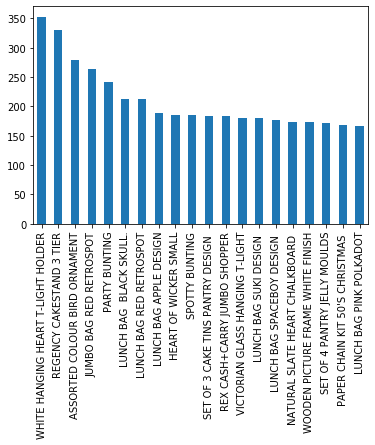

In [6]:
#Find out which 20 items have the most purchases
retail.Description.value_counts(sort=True)[:20].plot(kind="bar")
plt.show()

In [7]:
#As we see before, the type of InvoiceDate column is not right. Convert it into datetime type
retail.InvoiceDate = pd.to_datetime(retail.InvoiceDate)
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68191 entries, 12748 to 12680
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    68191 non-null  int64         
 1   StockCode    68191 non-null  object        
 2   Description  68191 non-null  object        
 3   Quantity     68191 non-null  int64         
 4   InvoiceDate  68191 non-null  datetime64[ns]
 5   UnitPrice    68191 non-null  float64       
 6   Country      68191 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 4.2+ MB


In [8]:
#Let's see the newest and the oldest recorded transaction day
print("Most recent invoice date : {}".format(retail.InvoiceDate.max()))
print("Oldest invoice date : {}".format(retail.InvoiceDate.min()))

Most recent invoice date : 2011-12-09 00:00:00
Oldest invoice date : 2010-12-10 00:00:00


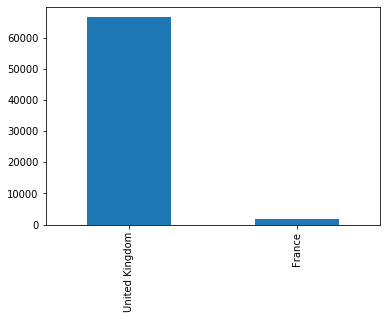

In [9]:
#Lastly, let's see which countries our customers from
retail.Country.value_counts().plot(kind="bar")
plt.show()

Now, we are in the first part of data modelling : RFM Model

RFM stands for Recency, Frequency and Monetary
    - Recency - Number of days since the last purchases
    - Frequency - Number of purchases
    - Monetary - Total amount of money customer spent

In [10]:
#Create a new column for calculating the revenue of the online retail (amount of money customer spent) for monetary part of 
#RFM model
retail["Revenue"] = retail.Quantity * retail.UnitPrice
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,Revenue
CustomerID,,,,,,,,
12748,581580,22908,PACK OF 20 NAPKINS RED APPLES,2,2011-12-09,0.85,United Kingdom,1.70
14446,581538,84380,SET OF 3 BUTTERFLY COOKIE CUTTERS,1,2011-12-09,1.45,United Kingdom,1.45
14446,581538,22197,POPCORN HOLDER,4,2011-12-09,0.85,United Kingdom,3.40
17754,581514,22075,6 RIBBONS ELEGANT CHRISTMAS,24,2011-12-09,0.39,United Kingdom,9.36
15311,581571,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,24,2011-12-09,2.55,United Kingdom,61.20


In [11]:
#Define date a day after the most recent transaction date for recency part of RFM model
snapshot_date = max(retail.InvoiceDate) + timedelta(days=1)
snapshot_date

Timestamp('2011-12-10 00:00:00')

In [12]:
#Create the RFM table grouped by Customer ID
retail_rfm = retail.groupby(['CustomerID']).agg({
    'InvoiceDate':lambda x: (snapshot_date-x.max()).days,
    'InvoiceNo' : 'count',
    'Revenue' : 'sum'})
retail_rfm.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','Revenue':'Monetary'}, inplace=True)
retail_rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12680,1,15,249.45
12747,3,25,948.70
12748,1,888,7046.16
12749,4,37,813.45
12820,4,17,268.02


In [13]:
#Create 3 quantile groups for recency, frequency and monetary
#Here, label 1 defines the highest recency, and the lowest frequency and monetary.
#Label 3 defines the lowest recency, and the highest frequency and monetary
#Customers with the lowest recency, highest frequency and monetary are considered highest customers
r_labels = range(3,0,-1)
f_labels = range(1,4)
m_labels = range(1,4)
r_group = pd.qcut(retail_rfm['Recency'],q=3,labels=r_labels)
f_group = pd.qcut(retail_rfm['Frequency'],q=3, labels=f_labels)
m_group = pd.qcut(retail_rfm['Monetary'],q=3, labels=m_labels)
retail_rfm = retail_rfm.assign(R=r_group, F=f_group, M=m_group)
retail_rfm.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12680,1,15,249.45,3,2,3
12747,3,25,948.70,3,3,3
12748,1,888,7046.16,3,3,3
12749,4,37,813.45,3,3,3
12820,4,17,268.02,3,3,3


Let's step into data pre-processing.

In [14]:
retail_rfm.describe()

,Recency,Frequency,Monetary
count,3644.000000,3644.000000,3644.000000
mean,90.411087,18.713227,370.661114
std,94.445168,43.748506,1347.260000
min,1.000000,1.000000,0.650000
25%,19.000000,4.000000,58.752500
50%,51.000000,9.000000,136.420000
75%,139.000000,21.000000,334.200000
max,365.000000,1497.000000,48060.350000


In the next step, data modelling, we are going to apply KMeans clustering.
In order to do that, we need to make sure the recency, frequency and monetary have the equal mean and standard deviation.
Also, those variables need to have a symetrical distribution.

On the output above, it is clear that the variables do not have the equal mean and standard deviation.

Let's see the distribution of the variables.

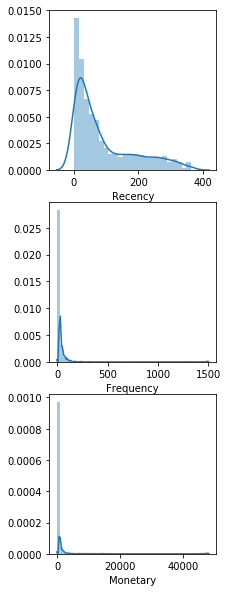

In [15]:
plt.figure(figsize=(3,10))
for i in range(len(retail_rfm.columns)-3):
    plt.subplot(3,1,i+1);sns.distplot(retail_rfm.iloc[:,i])
plt.show()

As we can see, all of the variables had skewness on their distribution.
To improve this, apply log transformation to the variables.

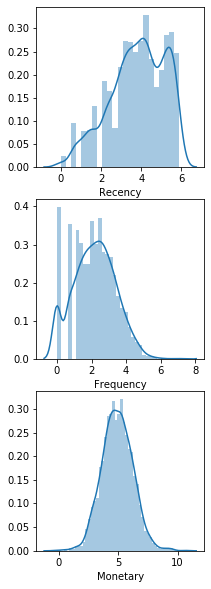

In [16]:
retail_rfm_log = np.log(retail_rfm.iloc[:,0:3])

plt.figure(figsize = (3,10))
for i in range(len(retail_rfm_log.columns)):
    plt.subplot(3,1,i+1);sns.distplot(retail_rfm_log.iloc[:,i])
plt.show()

We managed to improve the distribution of the variables.

Take a look again at the mean and standard deviation of recency, frequency and monetary variables

In [17]:
retail_rfm_log.describe()

,Recency,Frequency,Monetary
count,3644.000000,3644.000000,3644.000000
mean,3.805436,2.172049,4.935060
std,1.353914,1.210187,1.310801
min,0.000000,0.000000,-0.430783
25%,2.944439,1.386294,4.073333
50%,3.931826,2.197225,4.915738
75%,4.934474,3.044522,5.811739
max,5.899897,7.311218,10.780213


Well, the mean and the standard deviation of the three variables need more improvement

Try to apply the standard scaler to the variables 

In [18]:
ss = StandardScaler()
retail_rfm_norm = ss.fit_transform(retail_rfm_log)
retail_rfm_norm = pd.DataFrame(retail_rfm_norm, index = retail_rfm_log.index, 
                               columns=retail_rfm[['Recency', 'Frequency','Monetary']].columns)

Take a look at the distribution of each variable

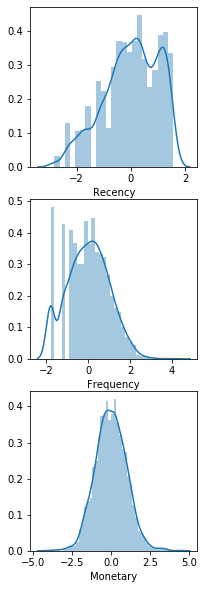

In [19]:
plt.figure(figsize=(3,10))
for i in range(len(retail_rfm_norm.columns)):
    plt.subplot(3,1,i+1);sns.distplot(retail_rfm_norm.iloc[:,i])
plt.show()

Then, take a look at the mean and the standard deviation of the variables

In [20]:
retail_rfm_norm.describe().round(2)

,Recency,Frequency,Monetary
count,3644.00,3644.00,3644.00
mean,-0.00,0.00,-0.00
std,1.00,1.00,1.00
min,-2.81,-1.80,-4.09
25%,-0.64,-0.65,-0.66
50%,0.09,0.02,-0.01
75%,0.83,0.72,0.67
max,1.55,4.25,4.46


The means are now almost equal to each other, while the standard deviations are equal to each other.
Notice that the means are close to zero and the standard deviations are 1.
It means, now the variables likely have a normal distribution.

Now, we are ready to do data modelling.

As we stated before, we are going to use k-means clustering.
First, we are going to apply elbow method to choose the best number of clusters.

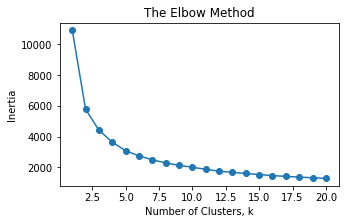

In [23]:
k_range = range(1,21)
inertia = []
for k in k_range :
    model = KMeans(n_clusters=k)
    model.fit(retail_rfm_norm)
    inertia.append(model.inertia_)
plt.figure(figsize=(5,3))
plt.plot(k_range, inertia,'-o')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.show()

The elbow is around 3-5 clusters.
Here, we'll use 4 clusters.

Extract the cluster labels from the normalized retail dataset with RFM variables

In [24]:
kmeans_k4 = KMeans(n_clusters=4)
kmeans_k4.fit(retail_rfm_norm)
cluster_labels = kmeans_k4.labels_

Define the centroids, data point at the center of the cluster, of each cluster label and variable

In [25]:
centroids = kmeans_k4.cluster_centers_
centroids = pd.DataFrame(centroids, columns = [retail_rfm_norm.columns])
centroids

,Recency,Frequency,Monetary
0,-0.807795,-0.025333,-0.168190
1,0.646503,0.075613,0.157714
2,0.759387,-1.160269,-1.105284
3,-0.965708,1.244572,1.206136


Now, let's visualize the centroids to see the behavior of each clusters based on recency, frequency and monetary

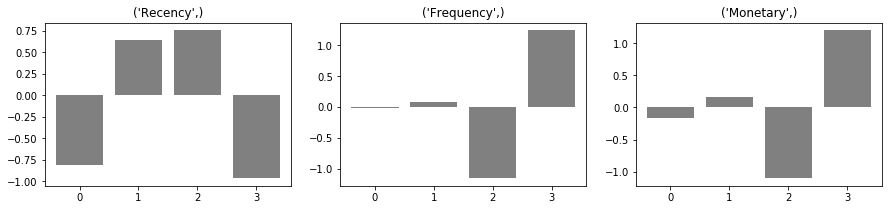

In [26]:
plt.figure(figsize = (15,3))
for i in range(len(centroids.columns)):
    plt.subplot(1,3,i+1)
    plt.bar(centroids.index, centroids.iloc[:,i], color = "gray")
    plt.title(centroids.columns[i])
plt.show()

Assign the clusters to the rfm dataset which are grouped by customer ID

In [27]:
retail_rfm_k4 = retail_rfm.assign(Cluster=cluster_labels)
retail_rfm_k4

,Recency,Frequency,Monetary,R,F,M,Cluster
CustomerID,,,,,,,
12680,1,15,249.45,3,2,3,0
12747,3,25,948.70,3,3,3,3
12748,1,888,7046.16,3,3,3,3
12749,4,37,813.45,3,3,3,3
12820,4,17,268.02,3,3,3,3
...,...,...,...,...,...,...,...
18280,278,2,38.70,1,1,1,2
18281,181,2,31.80,1,1,1,2
18282,8,2,30.70,3,1,1,0


Calculate the mean of recency, frequency and monetary of each cluster and count the number of customers in each cluster

In [28]:
retail_rfm_k4_grouped = retail_rfm_k4.groupby(['Cluster']).agg({'Recency':'mean','Frequency':'mean',
                                                               'Monetary':['mean','count']}).round(1)
retail_rfm_k4_grouped

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          19.5      10.4    146.0   769
1         129.5      11.8    231.6  1091
2         165.3       2.6     44.2   949
3          19.5      53.8   1130.3   835

To find out a better picture of the customer segmentation, let's see the RFM score

In [29]:
retail_rfm_k4['RFM'] = retail_rfm_k4["R"].astype(str)+retail_rfm_k4["F"].astype(str)+retail_rfm_k4["M"].astype(str)
retail_rfm_k4.head()

,Recency,Frequency,Monetary,R,F,M,Cluster,RFM
CustomerID,,,,,,,,
12680,1,15,249.45,3,2,3,0,323
12747,3,25,948.70,3,3,3,3,333
12748,1,888,7046.16,3,3,3,3,333
12749,4,37,813.45,3,3,3,3,333
12820,4,17,268.02,3,3,3,3,333


Take a look at the number of customers with certain RFM in each cluster. 
This will determine the characteristic of each cluster.

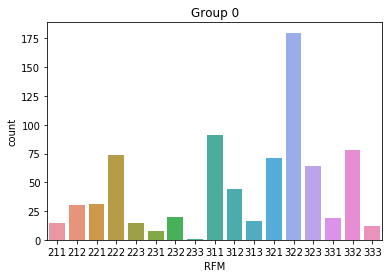

In [38]:
retail_rfm_group0 = retail_rfm_k4[retail_rfm_k4["Cluster"]==0]
sns.countplot(retail_rfm_group0.RFM)
plt.title("Group 0")
plt.show()

Customers in Group 0 are likely potential loyalist.

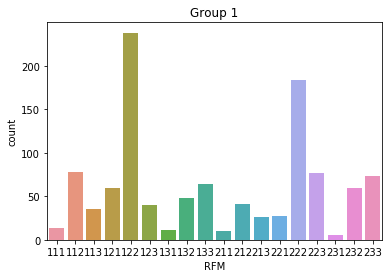

In [39]:
retail_rfm_group1 = retail_rfm_k4[retail_rfm_k4["Cluster"]==1]
sns.countplot(retail_rfm_group1.RFM)
plt.title("Group 1")
plt.show()

Customers in Group 1 likely need more attention.

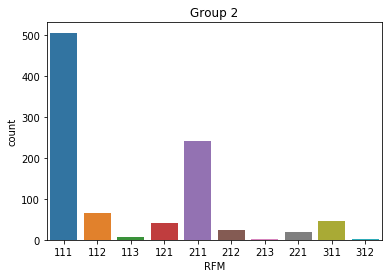

In [40]:
retail_rfm_group2 = retail_rfm_k4[retail_rfm_k4["Cluster"]==2]
sns.countplot(retail_rfm_group2.RFM)
plt.title("Group 2")
plt.show()

Customers in Group 2 are at risk about to stop buying items from the online retail.

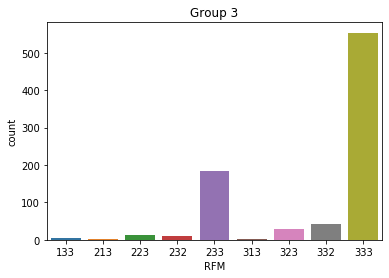

In [41]:
retail_rfm_group3 = retail_rfm_k4[retail_rfm_k4["Cluster"]==3]
sns.countplot(retail_rfm_group3.RFM)
plt.title("Group 3")
plt.show()

Customer in Group 3 are are likely the loyal ones

Name the clusters based on their characteristic
    1. Group 0 : Potential Loyalist
    2. Group 1 : Need Attention
    3. Group 2 : At Risk
    4. Group 3 : Loyal Customers

In [44]:
retail_rfm_k4.loc[retail_rfm_k4['Cluster']==0, 'Segment'] = "Potential Loyalist"
retail_rfm_k4.loc[retail_rfm_k4['Cluster']==1, 'Segment'] = "Need Attention"
retail_rfm_k4.loc[retail_rfm_k4['Cluster']==2, 'Segment'] = "At Risk"
retail_rfm_k4.loc[retail_rfm_k4['Cluster']==3, 'Segment'] = "Loyal Customers"
retail_rfm_k4.head()

,Recency,Frequency,Monetary,R,F,M,Cluster,RFM,Segment
CustomerID,,,,,,,,,
12680,1,15,249.45,3,2,3,0,323,Potential Loyalist
12747,3,25,948.70,3,3,3,3,333,Loyal Customers
12748,1,888,7046.16,3,3,3,3,333,Loyal Customers
12749,4,37,813.45,3,3,3,3,333,Loyal Customers
12820,4,17,268.02,3,3,3,3,333,Loyal Customers


In [45]:
#Save the result to csv file
retail_rfm_k4.to_csv(r"D:/datacamp/Python/Customer Segmentation/Online Retail.csv", header = True)